In [1]:
from datetime import datetime


from energy_box_control.power_hub.control import control_power_hub, initial_control_state
from energy_box_control.power_hub.network import PowerHub, PowerHubSchedules
from energy_box_control.schedules import ConstSchedule
from datetime import timedelta
from energy_box_control.power_hub.control import initial_control_all_off

import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

%load_ext autoreload 
%autoreload 2

%cd ..

sns.set_style("whitegrid")



/Users/alje/Repos/energy-box-control


/Users/alje/Repos/energy-box-control/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
def simulate_powerhub(schedules: PowerHubSchedules, control_function, steps: int, start_time: datetime = datetime.now(), step_size: timedelta = timedelta(seconds = 1)) -> tuple[pd.DataFrame, pd.DataFrame]:
    power_hub = PowerHub.power_hub(schedules)
    state = power_hub.simple_initial_state(start_time, step_size)
    control_state = initial_control_state()
    control_values = initial_control_all_off(power_hub)

    control_results = {}
    results = {}
    for _ in range(steps):
        state = power_hub.simulate(state, control_values)
        
        sensors = power_hub.sensors_from_state(state)
        
        control_state, control_values = control_function(power_hub, 
            control_state, sensors, state.time 
        )

        control_results[state.time.timestamp] = pd.DataFrame(
            {**{
                key: item.__dict__ 
                for key, item in control_values.name_to_control_values_mapping( 
                    power_hub
                ).items() 
            },**{'control_mode':{key: item.control_mode._value_ for key, item in control_state.__dict__.items() if key != 'setpoints'}}} 
            
        ).T.stack()

        results[state.time.timestamp] = pd.DataFrame(sensors.to_dict()).T.stack()

    control_data = pd.DataFrame(control_results).T
    data = pd.DataFrame(results).T

    return (data, control_data)

In [3]:
schedules = PowerHubSchedules.schedules_from_data()
# steps = 7*24
# step_size = timedelta(seconds = 60*60)

#schedules = PowerHubSchedules.const_schedules()
steps = 5*24*60
step_size = timedelta(seconds = 60)

In [8]:
data, control_data = simulate_powerhub(schedules, control_power_hub, steps, datetime(2017,6,1,0,0,0), step_size)

In [9]:
appliances = ["heat_pipes", "hot_reservoir", "pcm", "yazaki", "chiller", "cold_reservoir", "preheat_reservoir", "outboard_exchange"]
temperatures = [(appliance,var) for appliance, var in data.columns if 'temperature' in var and appliance in appliances]
powers = [(appliance,var) for appliance, var in data.columns if 'power' in var and appliance in appliances]

control_modes = control_data['control_mode']

def switch_stamps(control_modes, control_type):
    control_switch = (control_modes[control_type] != control_modes[control_type].shift(1))
    modes = control_modes[control_switch][control_type].to_frame()
    intervals = modes.reset_index(names = 'start_stamp').join(modes.reset_index(names = 'end_stamp').shift(-1)['end_stamp'])
    intervals.at[intervals.index[-1],'end_stamp'] = control_modes.index[-1]
    return intervals

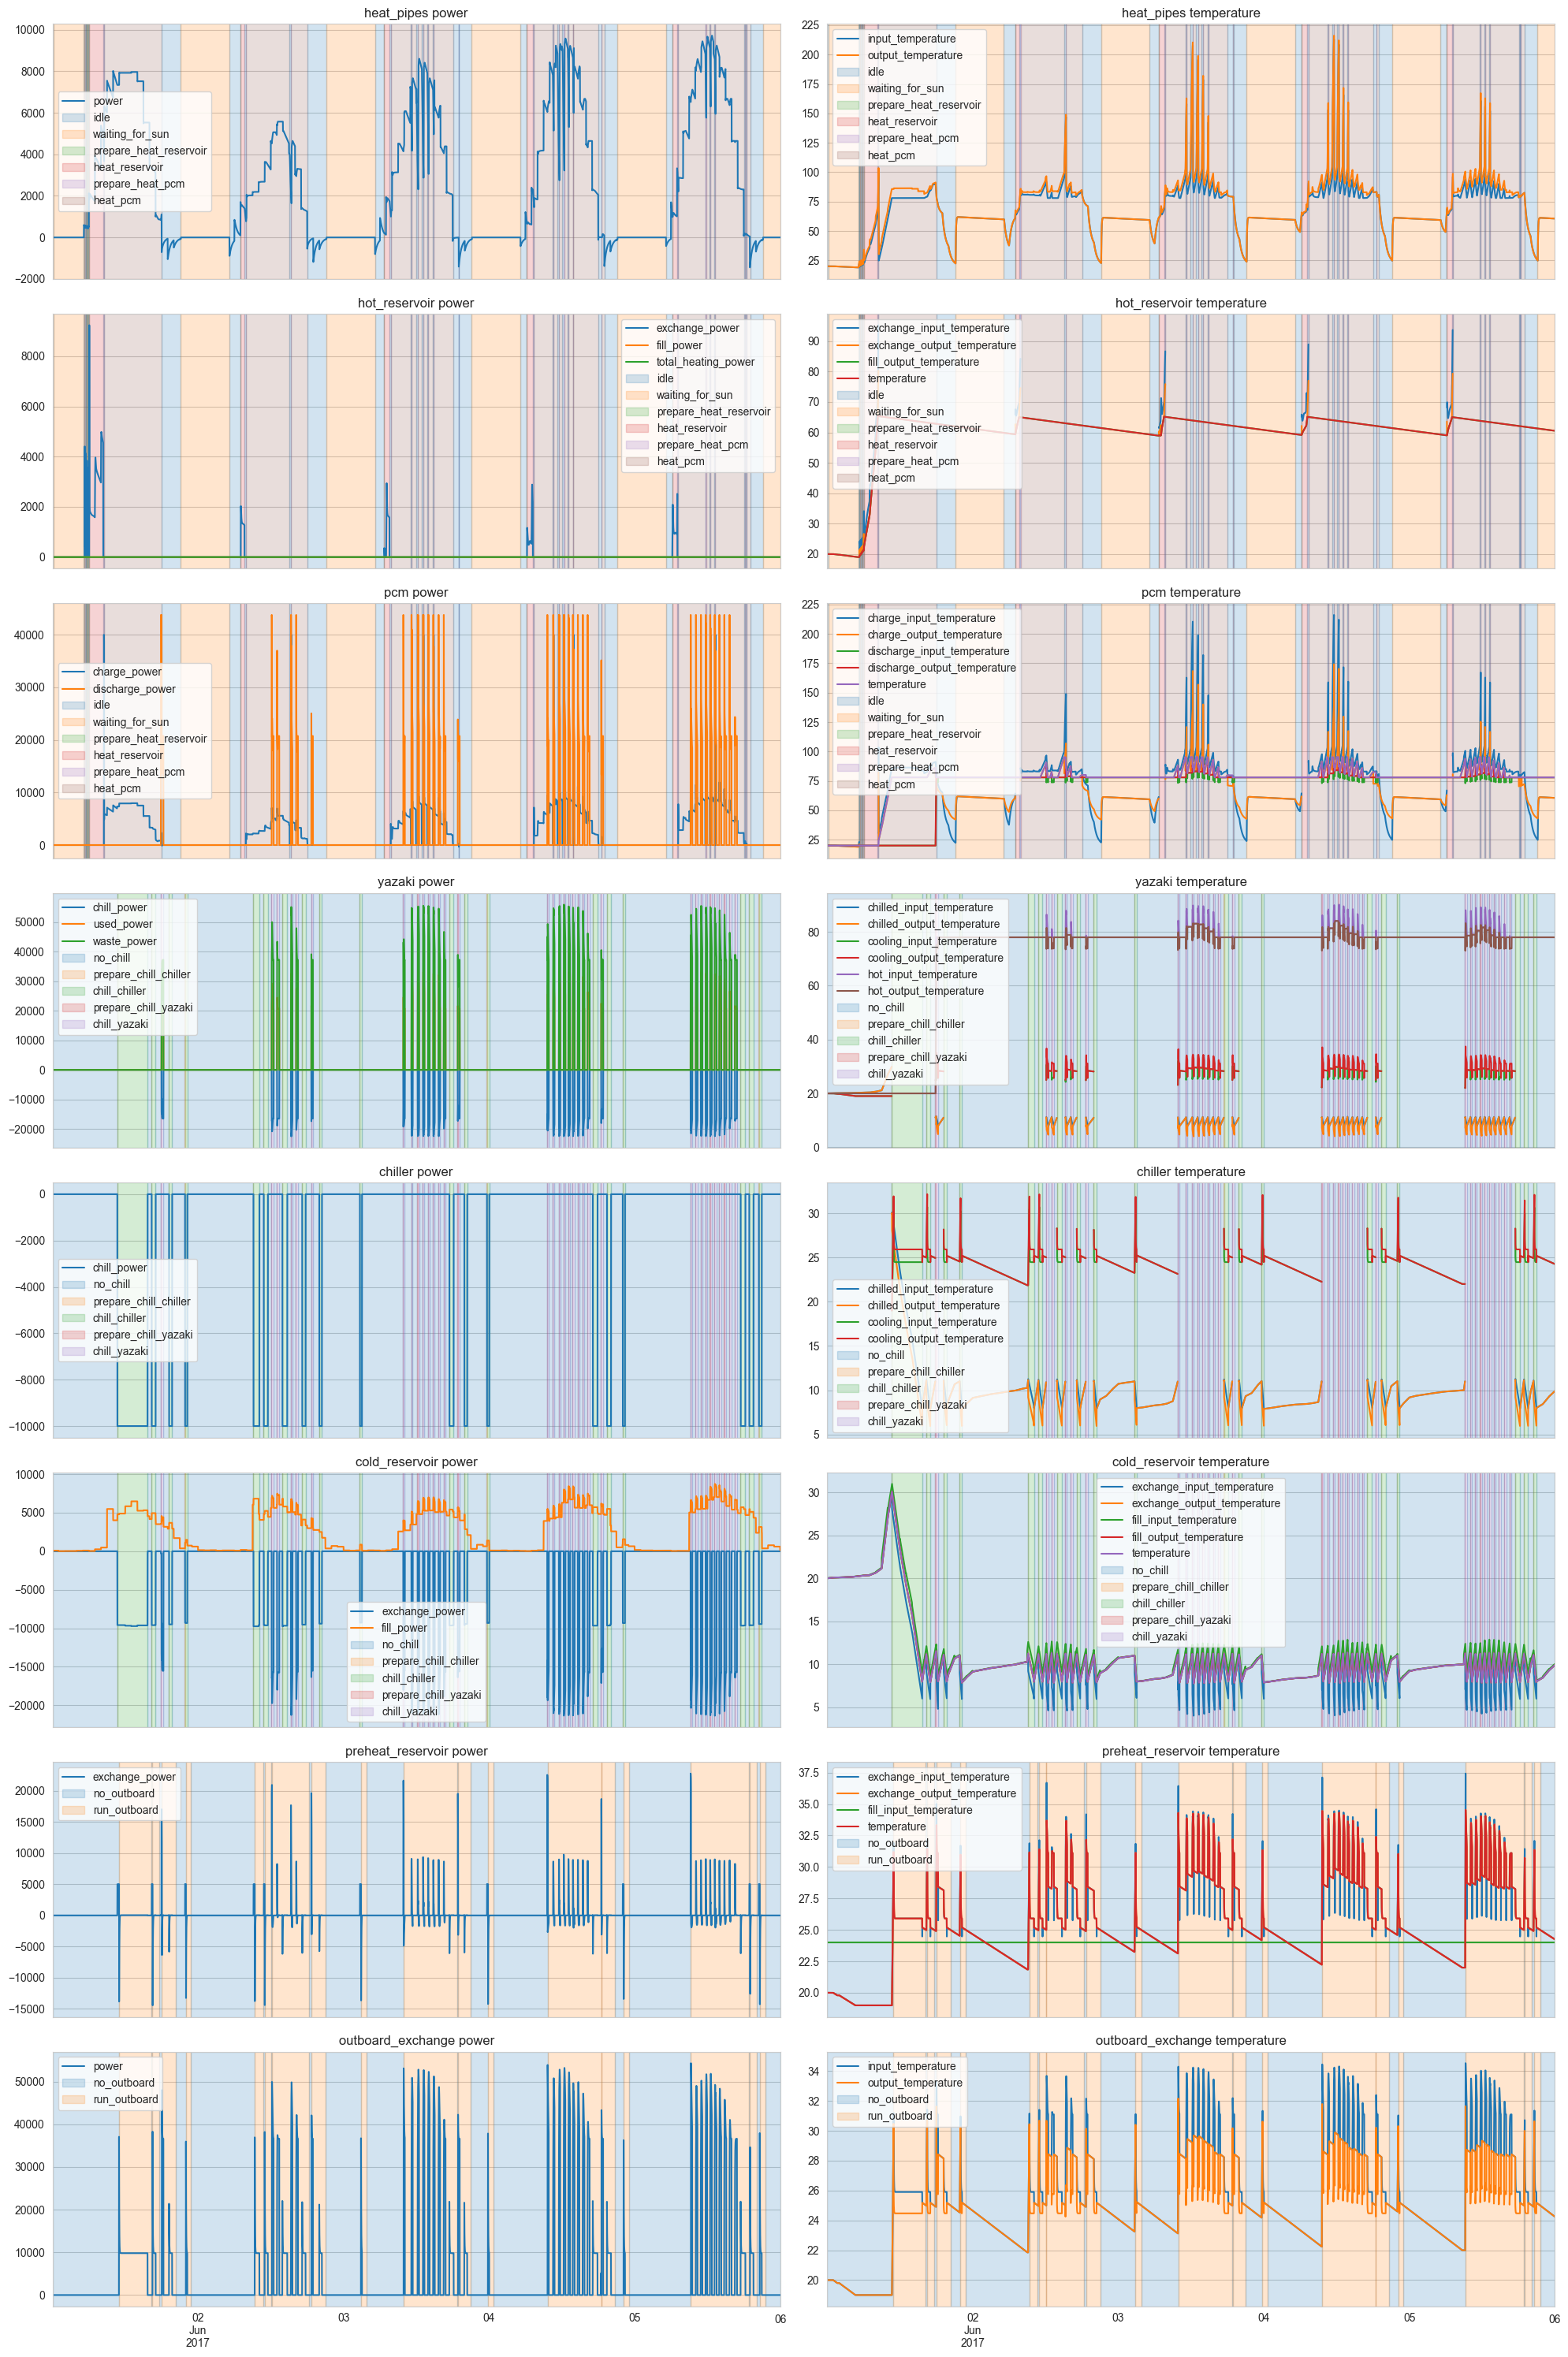

In [10]:
fig, axs = plt.subplots(len(appliances), 2, sharex = True, figsize = (20,30))


for i, appliance in enumerate(appliances):
    axs[i,0] = data[powers][appliance].plot(ax = axs[i,0], legend = False, title = appliance + ' power')
    axs[i,1] = data[temperatures][appliance].plot(ax = axs[i,1], legend = False, title = appliance + ' temperature')



    if appliance in ["heat_pipes", "hot_reservoir", "pcm"]:
        control_type = "hot_control"
    elif appliance in ["yazaki", "chiller", "cold_reservoir"]:
        control_type = "chill_control"
    elif appliance in ["preheat_reservoir", "outboard_exchange"]:
        control_type = "waste_control"
    else: control_type = None 

    if control_type:
        stamps = switch_stamps(control_modes, control_type)
        colors = {k:sns.color_palette()[i] for i,k in enumerate(stamps[control_type].unique())}
        for min, mode, max in stamps.itertuples(index = False):
            axs[i,0].axvspan(min, max, alpha = .2, label = mode, color = colors[mode])
            axs[i,1].axvspan(min, max, alpha = .2, label = mode, color = colors[mode])

    for ax in axs[i]:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc = "best")
    
plt.tight_layout()



In [7]:
control_data

chilled_loop_pump chiller chiller_switch_valve  \
                                   on      on             position   
2017-06-01 00:01:00             False   False                  0.0   
2017-06-01 00:02:00             False   False                  0.0   
2017-06-01 00:03:00             False   False                  0.0   
2017-06-01 00:04:00             False   False                  0.0   
2017-06-01 00:05:00             False   False                  0.0   
...                               ...     ...                  ...   
2017-06-05 23:56:00              True   False                  0.0   
2017-06-05 23:57:00              True   False                  0.0   
2017-06-05 23:58:00              True   False                  0.0   
2017-06-05 23:59:00              True   False                  0.0   
2017-06-06 00:00:00              True   False                  0.0   

                    cold_reservoir  control_mode                   \
                         heater_on chill_control      hot_control   
2017-06-01 00:01:00          False      no_chill             idle   
2017-06-01 00:02:00          False      no_chill             idle   
2017-06-01 00:03:00          False      no_chill             idle   
2017-06-01 00:04:00          False      no_chill             idle   
2017-06-01 00:05:00          False      no_chill             idle   
...                            ...           ...              ...   
2017-06-05 23:56:00          False  chill_yazaki  waiting_for_sun   
2017-06-05 23:57:00          False  chill_yazaki  waiting_for_sun   
2017-06-05 23:58:00          False  chill_yazaki  waiting_for_sun   
2017-06-05 23:59:00          False  chill_yazaki  waiting_for_sun   
2017-06-06 00:00:00          False  chill_yazaki  waiting_for_sun   

                                  cooling_demand_pump fresh_water_pump  \
                    waste_control                  on               on   
2017-06-01 00:01:00   no_outboard                True            False   
2017-06-01 00:02:00   no_outboard                True            False   
2017-06-01 00:03:00   no_outboard                True            False   
2017-06-01 00:04:00   no_outboard                True            False   
2017-06-01 00:05:00   no_outboard                True            False   
...                           ...                 ...              ...   
2017-06-05 23:56:00   no_outboard                True            False   
2017-06-05 23:57:00   no_outboard                True            False   
2017-06-05 23:58:00   no_outboard                True            False   
2017-06-05 23:59:00   no_outboard                True            False   
2017-06-06 00:00:00   no_outboard                True            False   

                    heat_pipes_pump  ... outboard_pump pcm_to_yazaki_pump  \
                                 on  ...            on                 on   
2017-06-01 00:01:00            True  ...         False              False   
2017-06-01 00:02:00            True  ...         False              False   
2017-06-01 00:03:00            True  ...         False              False   
2017-06-01 00:04:00            True  ...         False              False   
2017-06-01 00:05:00            True  ...         False              False   
...                             ...  ...           ...                ...   
2017-06-05 23:56:00           False  ...         False               True   
2017-06-05 23:57:00           False  ...         False               True   
2017-06-05 23:58:00           False  ...         False               True   
2017-06-05 23:59:00           False  ...         False               True   
2017-06-06 00:00:00           False  ...         False               True   

                    preheat_reservoir preheat_switch_valve waste_bypass_valve  \
                            heater_on             position           position   
2017-06-01 00:01:00             False                  0.0                0.0   
201